In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

In [5]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = resize(x_train, (x_train.shape[0], 32, 32, 1))
x_test = resize(x_test, (x_test.shape[0], 32, 32, 1))
# x_train = resize(x_train, (x_train.shape[0], 64, 64, 1))
# x_test = resize(x_test, (x_test.shape[0], 64, 64, 1))

nx_train = np.zeros((x_train.shape[0], 64, 64, 1))
nx_test = np.zeros((x_test.shape[0], 64, 64, 1))

for i in range(len(nx_train)):
    j = np.random.randint(0,3)
    k = np.random.randint(0,3)
#     j, k = 0, 0
    x = (j*16, j*16+32)
    y = (k*16, k*16+32)
    nx_train[i][x[0]:x[1], y[0]:y[1]] = x_train[i]
    
for i in range(len(nx_test)):
    j = np.random.randint(0,3)
    k = np.random.randint(0,3)
    x = (j*16, j*16+32)
    y = (k*16, k*16+32)
    nx_test[i][x[0]:x[1], y[0]:y[1]] = x_test[i]

In [6]:
# plt.imshow(nx_test[17].reshape(64,64))
print(nx_train.shape)

(60000, 64, 64, 1)


In [14]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(64,64,1), name='enc_in'),
        #tf.keras.layers.Conv2D(filters=int(32), kernel_size=(4,4), strides=(4,4), activation='relu', padding='valid', use_bias=True, name='conv1'),
        tf.keras.layers.Conv2D(filters=int(32), kernel_size=(2,2), strides=(2,2), activation='relu', padding='valid', use_bias=True, name='conv1'),
        tf.keras.layers.Conv2D(filters=int(64), kernel_size=(2,2), strides=(2,2), activation='relu', padding='valid', use_bias=True, name='conv2'),
        tf.keras.layers.Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), activation='sigmoid', padding='valid', name='pt_conv'),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(8,8), strides=(8,8), padding='valid', name='latent_conv', use_bias=True),
        tf.keras.layers.Flatten(name='latent'),
        
        tf.keras.layers.Dense(units=4*8*8*32, activation='relu', name='dense'),
        tf.keras.layers.Reshape(target_shape=(2*8, 2*8, 32), name='reshape'),
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='deconv1'),
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='deconv2'),
        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', name='dec_out')
    ]
)
print(model.summary())
model.compile(loss='mse', optimizer='rmsprop')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 32)        160       
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        8256      
_________________________________________________________________
pt_conv (Conv2D)             (None, 16, 16, 1)         65        
_________________________________________________________________
latent_conv (Conv2D)         (None, 2, 2, 16)          1040      
_________________________________________________________________
latent (Flatten)             (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8192)              532480    
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 32)       

In [ ]:
history = model.fit(nx_train, nx_train, validation_data=(nx_test, nx_test), batch_size=32, epochs=100, shuffle=True)

Epoch 1/100
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0066 - val_loss: 0.0038
Epoch 2/100
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 3/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 4/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 6/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
1873/1875 [============================>.] - ETA: 0s - loss: 0.0019

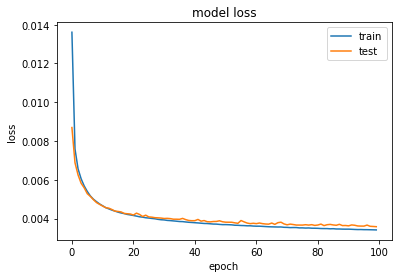

In [7]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

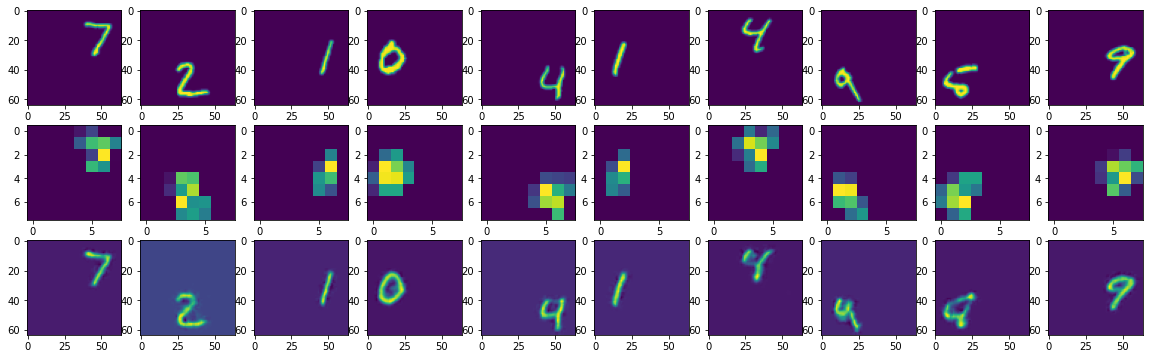

In [8]:
activation_model = tf.keras.models.Model(inputs=model.input, outputs=[model.get_layer('pt_conv').output, model.output])

plt.figure(figsize=(20, 6))
n = 10
for i in range(n):
    out1, out = activation_model.predict(nx_test[i].reshape(1,64,64,1))
    ax = plt.subplot(3, n, i+1)
    plt.imshow(nx_test[i].reshape(64,64))
    ax = plt.subplot(3, n, n+i+1)
    plt.imshow(out1.reshape(8,8))
#     plt.imshow(out1.reshape(4,4))
    ax = plt.subplot(3, n, 2*n+i+1)
    plt.imshow(out.reshape(64,64))

In [9]:
n_epochs = 100
model.save('../models/micae16split_%depochs'%n_epochs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/micae16split_100epochs/assets
